In [ ]:
!pip install pybullet==2.5.5

%cd /usr/local/lib/python3.6/dist-packages
!git clone https://github.com/benelot/pybullet-gym.git
%cd pybullet-gym
!pip install -e .

  Using cached https://files.pythonhosted.org/packages/d4/6c/6b14ae6d1d8f10f16ea82c2c194394564b02c80b88b6e391470046968c7b/pybullet-2.5.5.tar.gz
  Created wheel for pybullet: filename=pybullet-2.5.5-cp36-cp36m-linux_x86_64.whl size=71821347 sha256=792d427a96b1160c99d3d623817e458b3040f4290730b1e247835517b6b0d524
  Stored in directory: /root/.cache/pip/wheels/1d/e4/cc/7b50d6689e1bc6ba07d2df04946a0eabc89deca7caed5f52d1
Successfully built pybullet
/usr/local/lib/python3.6/dist-packages
fatal: destination path 'pybullet-gym' already exists and is not an empty directory.
/usr/local/lib/python3.6/dist-packages/pybullet-gym
Obtaining file:///usr/local/lib/python3.6/dist-packages/pybullet-gym
  Running setup.py develop for pybulletgym


In [ ]:
import gym
import pybulletgym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import numpy as np
from tqdm import trange
import glob
import io
import base64
from IPython.display import HTML

import torch
from torch import nn
import torch.nn.functional as F
from copy import deepcopy

from tqdm import tqdm, trange
import pandas as pd  # for recording progress
import torch.optim as optim
import pickle

from IPython import display as ipythondisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
CUDA = torch.cuda.is_available()

def to_np(x):
    return x.detach().cpu().numpy()

def to_tensor(x, requires_grad=False):
    x = torch.from_numpy(x)
    if CUDA:
        x = x.cuda()
    
    if requires_grad:
        return x.clone().contiguous().detach().requires_grad_(True)
    else:
        return x.clone().contiguous().detach()

    
class Network(nn.Module):
    
    def __init__(self):
        super(Network, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(111, 100),
            nn.Tanh(),
            nn.Linear(100, 8),
            nn.Tanh()
        )

        
    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)
    
    
    def set_params(self, params):
        cpt = 0
        for param in self.parameters():
            tmp = np.product(param.size())

            if torch.cuda.is_available():
                param.data.copy_(to_tensor(
                    params[cpt:cpt + tmp]).view(param.size()).cuda())
            else:
                param.data.copy_(to_tensor(
                    params[cpt:cpt + tmp]).view(param.size()))
            cpt += tmp

            
    def get_params(self):
        return deepcopy(np.hstack([to_np(v).flatten() for v in
                                   self.parameters()]))

In [ ]:
class CEM:
    
    def __init__(self, env, no_params, max_steps, max_train_steps, max_eval_steps, sigma_st, sigma_end, tau, pop_size, elitist=None, batch_size=100):
        self.env = env
        self.max_steps = max_steps
        self.max_train_steps = max_train_steps
        self.max_eval_steps = max_eval_steps
        self.sigma_st = sigma_st
        self.sigma_end = sigma_end
        self.tau = tau
        self.pop_size = pop_size
        self.elitist = elitist
        self.batch_size = batch_size
        
        if self.elitist is None:
            self.elitist = int(self.pop_size//2)
        
        self.no_params = no_params
        
        self.df = pd.DataFrame({'total_steps':[], 'min_eval': [], 'mean_eval': [], 'max_eval': [], 'mean_sigma': [], 'max_sigma': []})
        
    
    def run(self, start=0):
        actor = Network()
        mu = np.ones(self.no_params)
        sigma = self.sigma_st
        epsilon = 2
        
        if start != 0:
            epsilon = 0.1
            params = pickle.load(open(f'drive/My Drive/project_evo/history/{start}.pkl', 'rb'))['params']
            mu, sigma = params['mu'], params['sigma']
        
        replay_buffer = []
        
        total_steps = actor_steps = 0
        
        best, best_eval = None, -np.inf
        
        for total_steps in trange(start, self.max_steps, position=0, leave=True):
            pop = self._draw_population(mu, sigma)

            evals = np.zeros(self.pop_size)
            
            for i in range(self.pop_size):
                actor.set_params(pop[i])
                evals[i] = self._eval(actor)
            
            
            evals = np.maximum(0, evals)
            
            mu, sigma = self._update_params(pop, evals, mu, sigma, epsilon)
            epsilon = self.tau*epsilon + (1-self.tau)*(np.mean(self.sigma_end))
            
            if evals.max() > best_eval:
                best, best_best = pop[np.argmax(evals)], evals.max()
                
            if total_steps % 5 == 0:
                self.df = self.df.append({'total_steps': total_steps, 'min_eval': evals.min(), 'mean_eval': evals.mean(), 'max_eval': evals.max(), 'mean_sigma': sigma.mean(), 'max_sigma': sigma.max()}, ignore_index=True)
            
            if total_steps % 50 == 0:
                to_write = {'params': {'mu': mu, 'sigma': sigma, 'epsilon': epsilon},
                           'pop': pop,
                           'best': best}
                pickle.dump(to_write, open(f'drive/My Drive/project_evo/history/{total_steps}.pkl', 'w+b'), 
                            pickle.HIGHEST_PROTOCOL)

                best, best_eval = None, -np.inf
            
        return best
                
    
    def _draw_population(self, mu, sigma):
        pop = np.zeros((self.pop_size, self.no_params))
        for i in range(self.pop_size):
            pop[i] = np.random.normal(mu, np.sqrt(sigma))
        return pop
    
    
    def _eval(self, actor):
        '''
        evals actor by restaring env and doing max_eval_steps
        
        returns mean reward gained during eval
        '''
        observation = self.env.reset()
        observation = to_tensor(observation.reshape(1, -1).astype(np.float32))
        total_reward = 0

        for _ in range(self.max_eval_steps):
            action = actor(observation)
            action = to_np(action)[0]

            observation, reward, done, info = self.env.step(action)
            observation = to_tensor(observation.reshape(1, -1).astype(np.float32))
            
            if done:
                break
            
            total_reward += reward
        
        return total_reward/self.max_eval_steps
    
    
    def _update_params(self, pop, evals, old_mu, old_sigma, epsilon):
        lambdas = np.array([np.log(1+self.elitist)/(1+i) for i in range(self.elitist)]).reshape(-1, 1)
        lambdas /= (lambdas.sum()+1e-10)
#         lambdas = np.full(self.elitist, 1/self.elitist)
        idxs = np.argsort(evals)[::-1][:self.elitist]
        z = pop[idxs]
        
        mu = np.sum([lambdas[i]*z[i] for i in range(self.elitist)], axis=0)

        sigma = np.sum([lambdas[i]*(z[i] - old_mu)**2 for i in range(self.elitist)], axis=0)
        sigma += epsilon
        
        sigma = np.clip(sigma, 0.4, 20)
        
        return mu, sigma
    
    
    def _loss_func(self, reward):
        return 1 / (reward+1e-10)

In [ ]:
n = Network()
n.get_params().shape

(12008,)

In [ ]:
cem = CEM(env=gym.make('AntMuJoCoEnv-v0'), no_params=12008, max_steps=3001, max_eval_steps=250,
          max_train_steps=25, sigma_st=np.full(12008, 3),
          sigma_end=np.full(12008, 1e-4), tau=0.99, pop_size=100)

current_dir=/usr/local/lib/python3.6/dist-packages/pybullet_envs/bullet
WalkerBase::__init__


In [ ]:
best = cem.run(2600)

  0%|          | 0/401 [00:00<?, ?it/s]

options= 


100%|██████████| 401/401 [4:34:03<00:00, 41.01s/it]


In [ ]:
best

array([ -7.88465607, -12.89635667,  35.06605371, ...,   6.45113151,
         9.11775116,  18.59347907])

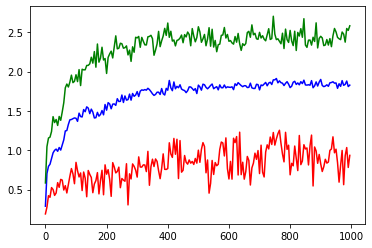

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(cem.df))*5, cem.df['mean_eval'], c='b')
plt.plot(np.arange(len(cem.df))*5, cem.df['min_eval'], c='r')
plt.plot(np.arange(len(cem.df))*5, cem.df['max_eval'], c='g')

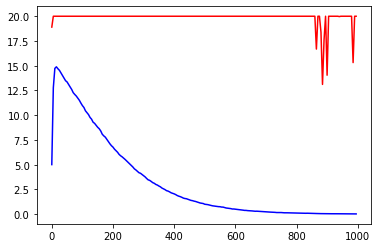

In [ ]:
plt.plot(np.arange(len(cem.df))*5, cem.df['mean_sigma'], c='b')
plt.plot(np.arange(len(cem.df))*5, cem.df['max_sigma'], c='r')